In [1]:
import cv2 as cv
import numpy as np
import os

print(f'openCV verions {cv.__version__}')

openCV verions 4.5.4


## Get Info about a Video

Let's open a video file and learn about it. You can extract information about a video using OpenCV. There are a whole bunch of [useful video properties documented here](https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#ggaeb8dd9c89c10a5c63c139bf7c4f5704da7c2fa550ba270713fca1405397b90ae0), but I pulled out some I thought were useful.

In [2]:
path_to_video = "../input/dfl-bundesliga-data-shootout/clips/08fd33_0.mp4"
vid_cap = cv.VideoCapture(path_to_video)

#Print Info about the video file

print("Video Info")
print("==========")

vid_width     = vid_cap.get(cv.CAP_PROP_FRAME_WIDTH) # Width of frame
print(f"width: {vid_width} pixels")

vid_height    = vid_cap.get(cv.CAP_PROP_FRAME_HEIGHT) # Height of frame
print(f"height: {vid_height} pixels")

vid_fps       = vid_cap.get(cv.CAP_PROP_FPS) # Frame rate in frames per second
print(f"fps: {vid_fps} frames per second")

vid_tot_frame = vid_cap.get(cv.CAP_PROP_FRAME_COUNT) # Number of frames in video
print(f"total frames: {vid_tot_frame} frames")

vid_cur_pos_ms = vid_cap.get(cv.CAP_PROP_POS_MSEC) # The current position of video file in milliseconds
print(f"current position: {vid_cur_pos_ms} ms")

vid_length = vid_tot_frame/vid_fps
print(f"length: {vid_length} seconds")

Video Info
width: 1920.0 pixels
height: 1080.0 pixels
fps: 25.0 frames per second
total frames: 750.0 frames
current position: 0.0 ms
length: 30.0 seconds


In [3]:
try:
    frame_folder = os.mkdir('frames')
    
except:
    print("Folder 'frames' already exists.")
    
frame_folder = "./frames"

In [4]:
def getFrame(vid_cur_pos_ms, frame_path):
    vid_cap.set(cv.CAP_PROP_POS_MSEC, vid_cur_pos_ms)  # set current position, described in milliseconds
    success_flag, image = vid_cap.read()              # grab a frame
   
    #Rescale 

    if success_flag:
       cv.imwrite(frame_path, image)     # save frame as JPG file
    return success_flag

Let's save an image for each second of the video

In [5]:
save_count = 0
frame_paths = []

while True:
    frame_name = str(save_count) + '.jpg'
    frame_path = os.path.join(frame_folder, frame_name)
    sucess_flag = getFrame(vid_cur_pos_ms, frame_path)
    
    if sucess_flag == False:
        print(f"Successfully saved {save_count} frames.")
        vid_cap.release()
        break
    
    frame_paths.append(frame_path) # add to list of paths
    vid_cur_pos_ms += 1000         # Bump the video forward 1 second's worth of frames
    save_count += 1                # Bump the save number forward 1

Successfully saved 30 frames.


## Pretrained TensorFlow Models

Now, let's download a pretrained model to use for Object Detection. Note that for the [DFL - Bundesliga Data Shootout competition](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout), you cannot use the internet, so this method does not work (and I haven't figured out the workaround). However, to test out some pretrained models, this works great!

I used [this tutorial video](https://www.youtube.com/watch?v=2yQqg_mXuPQ) for a guide.

[TensorFlow Object Detection Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) has a bunch of object detection models.

In [6]:
import tensorflow as tf
import time
from tensorflow.python.keras.utils.data_utils import get_file
from matplotlib import pyplot as plt

# Set Random seed for reproducability
np.random.seed(23)   

### Detector Class

In [7]:
class Detector:
    def __init__(self):
        pass
    
    def readClasses(self, classesFilePath):
        
        self.classesList = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
                             'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                             'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                             'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
                             'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
                             'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 
                             'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 
                             'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                             'toothbrush']

        self.colorList = np.random.uniform(low=0, high=255, size=(len(self.classesList), 3))
        
       
    def downloadModel(self, modelURL):
        fileName = os.path.basename(modelURL)
        self.modelName = fileName[:fileName.index('.')]
        
        # Folder for saving pretrained models
        self.cacheDir = "./pretrained_models"
        os.makedirs(self.cacheDir, exist_ok=True)

        # Download the pretrained model
        get_file(fname=fileName, origin=modelURL, cache_dir=self.cacheDir, cache_subdir="checkpoints", extract=True)
        
           
    def loadModel(self):
        print(f"Loading Model {self.modelName}")
        tf.keras.backend.clear_session()
        self.model = tf.saved_model.load(os.path.join(self.cacheDir, "checkpoints", self.modelName, "saved_model"))
        print(f"Model {self.modelName} Loaded Sucessfully!")
        
    def createBoundingBox(self, image, threshold=0.5):
        inputTensor = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)
        inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8)
        inputTensor = inputTensor[tf.newaxis,...]

        detections = self.model(inputTensor)
        
#         print(detections.keys())
        bboxs = detections['detection_boxes'][0].numpy()
        classIndexes = detections['detection_classes'][0].numpy().astype(np.int32)
        classScores = detections['detection_scores'][0].numpy()

        
        imH, imW, imC = image.shape
        
        # Cap number of bounding boxes. iou is the overlap of the bounding boxes, confidence threshold is score_threshold
        bboxsIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size=50, iou_threshold=0.2, score_threshold=threshold)
        
        
        
        if len(bboxsIdx) != 0:
            print("Drawing Bounding Boxes")
            for i in bboxsIdx:
                bbox = tuple(bboxs[i].tolist())
                classConfidence = round(100*classScores[i])
                classIndex = classIndexes[i] - 1 # Somehow the idexing is off by one. (see the bicycle picture labeled as a car.)
                
                classLabelText = self.classesList[classIndex]
                classColor = self.colorList[classIndex]
                displayText = f'{classLabelText}: {classConfidence}'
                
                ymin, xmin, ymax, xmax = bbox
                
                xmin, xmax, ymin, ymax = (xmin*imW, xmax*imW, ymin*imH, ymax*imH)
                xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax) 
                
                image = cv.rectangle(image, (xmin, ymin), (xmax, ymax), color=classColor, thickness=2)
                image = cv.putText(image, displayText, (xmin, ymin-10), cv.FONT_HERSHEY_PLAIN, 1, classColor, 2)
                
            return image
        else:   
            print("No bounding boxes found.")
            return image

                             
                             
    def predictImage(self, imagePath, threshold=0.5):
        image = cv.imread(imagePath)    
        
        bbox_image = self.createBoundingBox(image, threshold)
        
        cv.imwrite(f"{self.modelName}.jpg", bbox_image)
        plt.figure(figsize=(bbox_image.shape[0]//50, bbox_image.shape[1]//50))
        plt.imshow(bbox_image)


394477568/394474998 [==============================] - 6s 0us/step
Loading Model efficientdet_d7_coco17_tpu-32


2022-09-13 06:36:07.354051: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model efficientdet_d7_coco17_tpu-32 Loaded Sucessfully!


2022-09-13 06:37:09.089242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Drawing Bounding Boxes


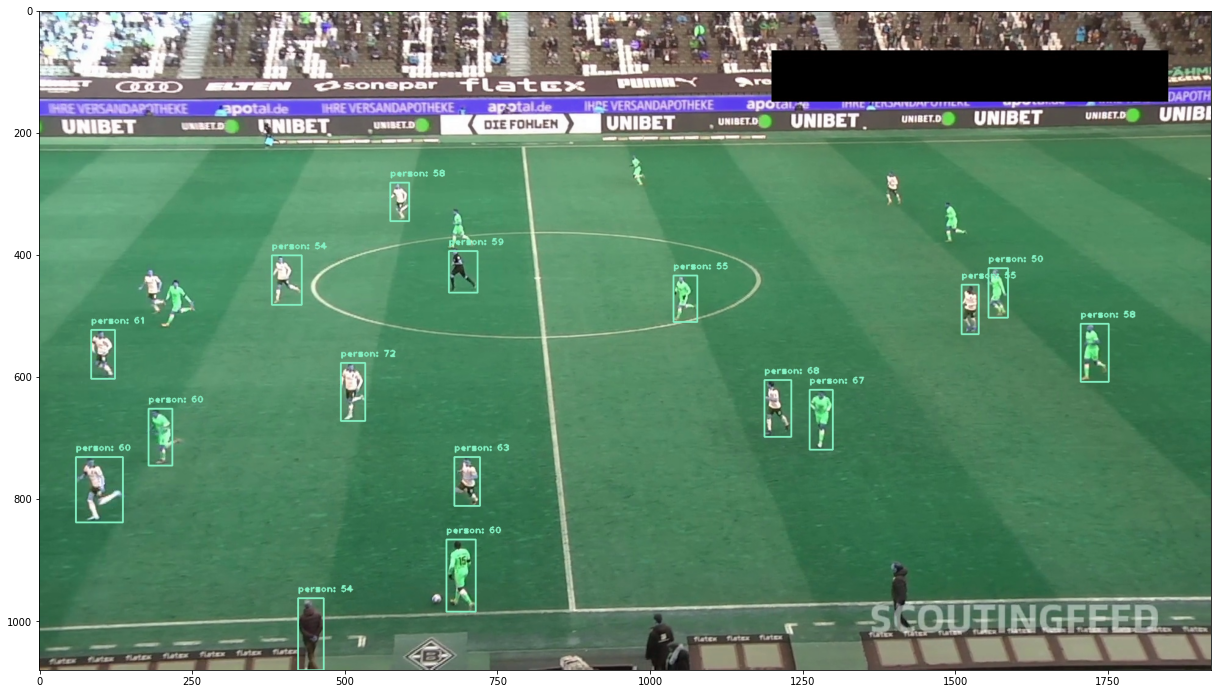

In [8]:
modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d7_coco17_tpu-32.tar.gz" #"http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz"
classFile = ''
imagePath = frame_paths[25]
threshold = 0.5
detector = Detector()
detector.readClasses(classFile)
detector.downloadModel(modelURL)
detector.loadModel()
detector.predictImage(imagePath, threshold)